# Active acoustic data analysis for 18Hz **and** 38Hz data
**Explore data :** 
1) **Data structure** : NetCDF4 : its variables
2) **Time dimension** : How many sample by seasons / year ? At what time was the data recorded ?
3) **Space dimension** : Where was the data recorded ?
4) **Time and space dimensions** : The data at the time and location it was recorded

#### Imports

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from data_extraction_functions import get_datetime, get_season

#### Open folder containing CDF files

In [2]:
folder_path = "../data/IMOS_18_and_38_Hz"
list_cdf_files = []

# Create list of nc files
for filename in os.listdir(folder_path) :
    if filename.endswith('.nc') : 
        filepath = os.path.join(folder_path, filename)
        list_cdf_files.append(filepath)

## Explore data

### 1) Data structure

#### Open CDF files

In [13]:
# File i
i = 3
cdf_file = list_cdf_files[i]

# Open file i
dataset=Dataset(cdf_file, mode='r')

#### Extract data from CDF file

In [14]:
# Show variables of CDF file
variable_names = np.array(list(dataset.variables.keys()))
# Display number of variables and some of them
print("number of variables : ", variable_names.shape, "\n", variable_names[:10], "...")


number of variables :  (103,) 
 ['TIME' 'DEPTH' 'CHANNEL' 'EV_FILENAME' 'LATITUDE'
 'LATITUDE_quality_control' 'LONGITUDE' 'LONGITUDE_quality_control'
 'mean_height' 'mean_height_quality_control'] ...


In [15]:
# Extract variables from dataset
latitude = dataset.variables['LATITUDE'][:]
longitude = dataset.variables['LONGITUDE'][:]
depth = dataset.variables.get('DEPTH', dataset.variables.get('RANGE', None))[:]
sv = dataset.variables['Sv'][:]
time = get_datetime(dataset)

In [17]:
# Display variables
print("Longitude : ", longitude[0:10])
print("Latitude : ", latitude[0:10])
print("Depth : ", depth[0:10]) # 240 levels of depth, of shape (240,)
print("Sv : ", sv[0:10]) # 2 or 4 channels, of shape(time, depth, channels)
print("Formatted date : ", time[0:10])
print("longitude : ", longitude.shape, ", latitude : ", latitude.shape, ", depth : ", depth.shape, ", sv : ",  sv.shape, ", date : ", time.shape)


Longitude :  [113.40711649 113.40846409 113.40982016 113.41113533 113.41223729
 113.41360415 113.4149929  113.41609218 113.41745261 113.41880565]
Latitude :  [-46.03107651 -46.03097876 -46.03087692 -46.03080238 -46.03072262
 -46.03063497 -46.03053169 -46.0304625  -46.03036622 -46.03027889]
Depth :  [ 2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5]
Sv :  [[[-- -- -- --]
  [-- -- -- --]
  [1.4251009535307279e-08 1.7993472104585186e-09 2.601560962574836e-10
   6.629377720068183e-10]
  ...
  [5.613346063560099e-09 -- -- --]
  [4.842026028936939e-09 -- -- --]
  [-- -- -- --]]

 [[-- -- -- --]
  [-- -- -- --]
  [1.3754222228050934e-08 2.991425437617901e-09 3.284916663943476e-11
   8.249818936211682e-11]
  ...
  [7.904631725803673e-09 -- -- --]
  [3.7322319773423925e-09 -- -- --]
  [-- -- -- --]]

 [[-- -- -- --]
  [-- -- -- --]
  [1.1116279362050482e-08 1.4085905836948612e-09 2.949312356355412e-11
   5.3449170487639294e-11]
  ...
  [4.845018519633726e-09 -- -- --]
  [4.69088563267373e-09 -

#### Plot Echogram

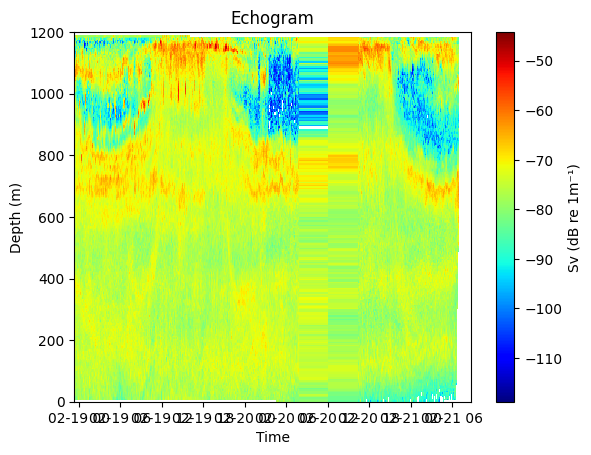

In [18]:
# Create figure
plt.figure()

# Select channel of sv 
channel = 0 # Channel = frequency of sonar
sv_data = sv[:, :, channel]

# Invert depth var
depth = depth[::-1]

# Plot
plt.pcolormesh(time, depth, 10 * np.log10(sv_data.T), shading='auto', cmap='jet')

# Labels and title
plt.colorbar(label="Sv (dB re 1m⁻¹)")
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Echogram")
plt.show()

plt.show()

#### Close CDF file

In [19]:
dataset.close()

### 2) Time dimension

#### List avaible datasets by season/month/frequency

In [3]:
for i in range(len(list_cdf_files)):
    # Open file
    cdf_file = list_cdf_files[i]
    dataset=Dataset(cdf_file, mode='r')

    # Extract date
    times=get_datetime(dataset)
    seasons = get_season(dataset)
    print(times)
    print(seasons)
    
    # Close dataset
    dataset.close()

[datetime.datetime(2017, 3, 18, 16, 9, 59)
 datetime.datetime(2017, 3, 18, 16, 10, 18)
 datetime.datetime(2017, 3, 18, 16, 10, 37) ...
 datetime.datetime(2017, 3, 24, 10, 6, 20)
 datetime.datetime(2017, 3, 24, 10, 6, 37)
 datetime.datetime(2017, 3, 24, 10, 6, 54)]
{2017: ['spring']}
[datetime.datetime(2016, 2, 16, 1, 57, 8)
 datetime.datetime(2016, 2, 16, 1, 57, 23)
 datetime.datetime(2016, 2, 16, 1, 57, 39) ...
 datetime.datetime(2016, 2, 18, 23, 19, 34)
 datetime.datetime(2016, 2, 18, 23, 19, 51)
 datetime.datetime(2016, 2, 18, 23, 20, 5)]
{2016: ['winter']}
[datetime.datetime(2017, 5, 17, 0, 20, 22)
 datetime.datetime(2017, 5, 17, 0, 20, 41)
 datetime.datetime(2017, 5, 17, 0, 20, 56) ...
 datetime.datetime(2017, 5, 23, 0, 5, 21)
 datetime.datetime(2017, 5, 23, 0, 6, 26)
 datetime.datetime(2017, 5, 23, 0, 7, 20)]
{2017: ['spring']}
[datetime.datetime(2016, 2, 18, 23, 20, 30)
 datetime.datetime(2016, 2, 18, 23, 20, 47)
 datetime.datetime(2016, 2, 18, 23, 21, 4) ...
 datetime.datetime(